In [67]:
# Loading dependencies
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
from collections import Counter
import seaborn as sns
import numpy as np
from typing import List
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from nltk.corpus import stopwords
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
import eli5

import nltk

from sklearn.metrics import accuracy_score, classification_report

from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import cloudpickle
from typing import Optional, Any, List, Dict
from scipy.stats import randint
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
)
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [36]:
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\empar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\empar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\empar\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# Loading data

In [37]:

df = pd.read_csv("./data/Ukraine_10K_tweets_sentiment_analysis.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10167 entries, 0 to 10166
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Tweet         9999 non-null   object 
 1   polarity      9999 non-null   float64
 2   subjectivity  9999 non-null   float64
 3   Sentiment     9999 non-null   object 
dtypes: float64(2), object(2)
memory usage: 317.8+ KB


In [6]:
df.head(20)

,Tweet,polarity,subjectivity,Sentiment
0,RT @ChristopherJM: Zelensky also confirms CIA ...,0.000000,0.000000,Negative
1,RT @oryxspioenkop: Russia acquired these vehic...,-0.100000,0.300000,Positive
2,RT @RepMTG: I’m calling for an audit of every ...,-0.035714,0.607143,Positive
3,"RT @KyivIndependent: ""Russian goal seems to be...",0.034091,0.113636,Negative
4,RT @william98161886: I see Rishi just given an...,-0.325521,0.166667,Positive
5,RT @UmlandAndreas: https://t.co/jJMGEpdEn2,0.000000,0.000000,Negative
6,RT @michaeldweiss: Predicting the trajectory a...,0.433333,0.733333,Negative
7,"RT @IuliiaMendel: If Putin took over Ukraine, ...",-0.187500,0.500000,Positive
8,https://t.co/cCyzHS5How Ukraine: Bewohnerin vo...,0.000000,0.000000,Negative
9,Can the risk of spillover from the Ukraine war...,0.000000,0.000000,Negative


# Cleaning data

In [38]:

df.dropna(inplace=True)

In [94]:
df.isnull().sum()

Tweet           0
polarity        0
subjectivity    0
Sentiment       0
dtype: int64

In [39]:
# remove dublicates
print(f"Size before: {df.size} {df.shape}")
df = df.drop_duplicates()
print(f"Size after: {df.size} {df.shape}")

Size before: 39996 (9999, 4)
Size after: 10976 (2744, 4)


# Look at data

In [96]:
df["is_tweet_positive"] = (df["Sentiment"] == "Positive").astype(int)

In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2744 entries, 0 to 9995
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Tweet              2744 non-null   object 
 1   polarity           2744 non-null   float64
 2   subjectivity       2744 non-null   float64
 3   Sentiment          2744 non-null   object 
 4   is_tweet_positive  2744 non-null   int32  
dtypes: float64(2), int32(1), object(2)
memory usage: 117.9+ KB


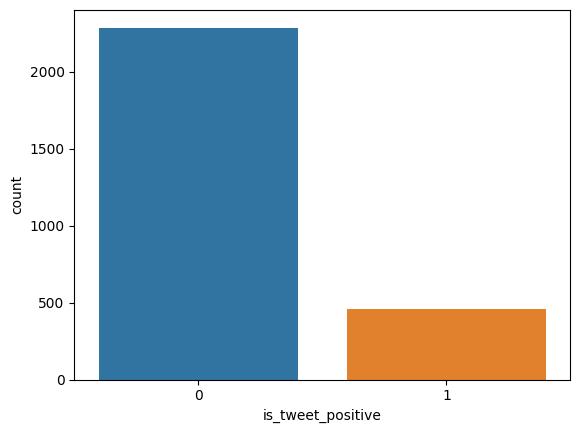

In [98]:
sns.countplot(x="is_tweet_positive",data=df)
plt.show()

# Let's look at Sentiment dependece from polarity

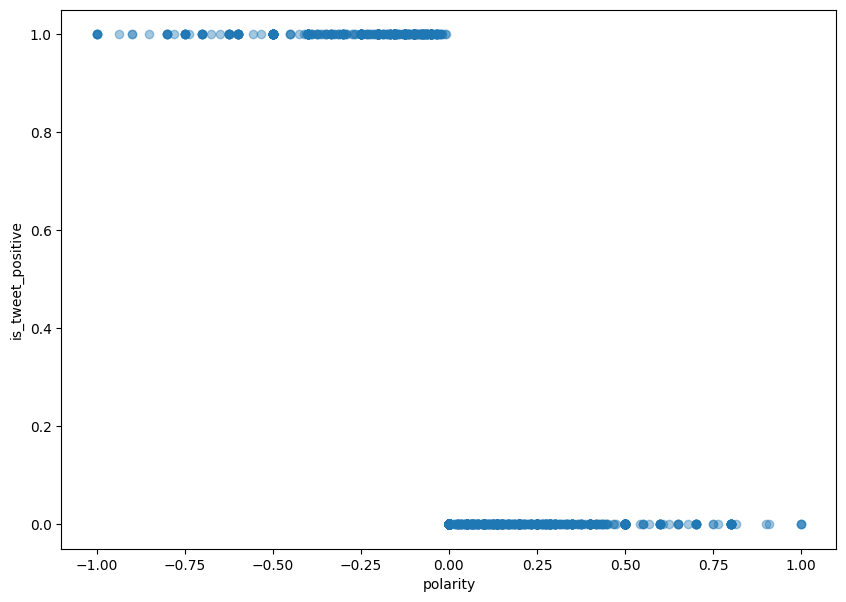

In [99]:
plt.figure(figsize=(10, 7))
plt.scatter(x="polarity", y="is_tweet_positive", data=df, alpha=0.4)
plt.xlabel("polarity")
plt.ylabel("is_tweet_positive")
plt.show()

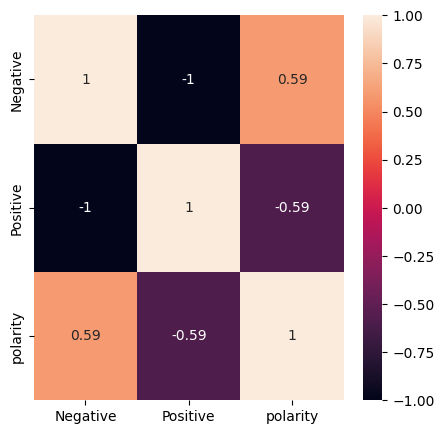

In [103]:
plt.figure(figsize=(5, 5))
corr = pd.concat([pd.get_dummies(df["Sentiment"]), df[["polarity"]]], axis=1).corr()
sns.heatmap(corr, annot=True,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show()

# Now we try make baseline with polarity as we can most data show that if polaryti is <=0 Sentiment is negative

In [164]:
class BaselinePredictor:
    def __init__(self) -> None:
        self._polarity = 0.0
        self._Sentiment = []
   
    
    def predict(self, X: list) -> int:
        for i in X:
            
            if i>=0:
                Sentimentt = 0
            else:
                Sentimentt = 1
            self._Sentiment.append(Sentimentt)
        return self._Sentiment 


In [165]:
baseline = BaselinePredictor()


df[["polarity", "Sentiment"]].head(20)

,polarity,Sentiment
0,0.000000,Negative
1,-0.100000,Positive
2,-0.035714,Positive
3,0.034091,Negative
4,-0.325521,Positive
5,0.000000,Negative
6,0.433333,Negative
7,-0.187500,Positive
8,0.000000,Negative
9,0.000000,Negative


In [163]:
print(baseline.predict([-0.400000 , -0.155000, 0, 0.5]))


-0.4
-0.155
0
0.5
[1, 1, 0, 0]


In [147]:
print(baseline.predict([-0.155000]))

1


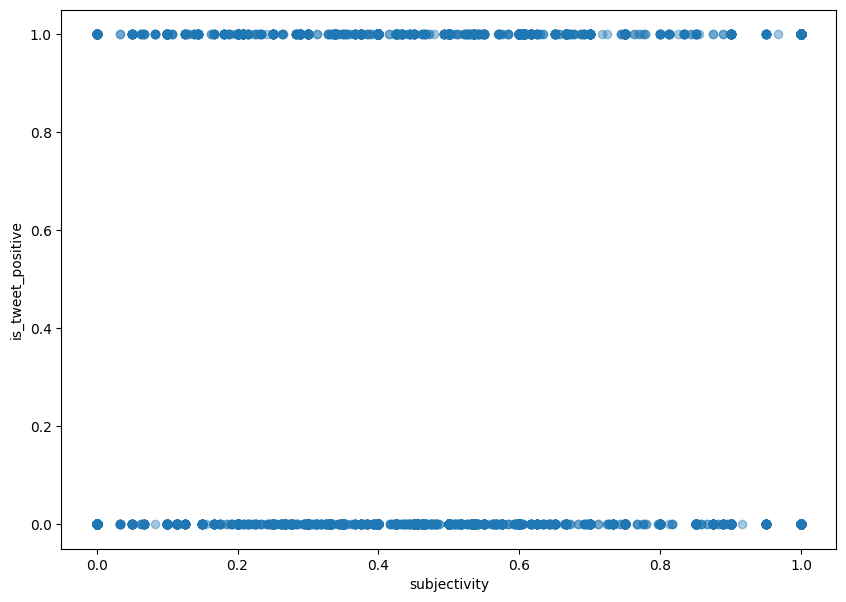

In [799]:
plt.figure(figsize=(10, 7))
plt.scatter(x="subjectivity", y="is_tweet_positive", data=df, alpha=0.4)
plt.xlabel("subjectivity")
plt.ylabel("is_tweet_positive")
plt.show()

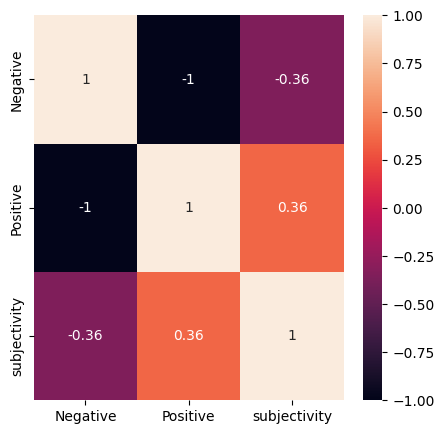

In [104]:
plt.figure(figsize=(5, 5))
corr = pd.concat([pd.get_dummies(df["Sentiment"]), df[["subjectivity"]]], axis=1).corr()
sns.heatmap(corr, annot=True,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show()

# As we can see subjectivity have values in both side, that would't help to our model get better 

# let's look at 10 positive reviews

In [105]:
for value in df.loc[df["Sentiment"] == "Positive"].head(10).Tweet.values:
    print(value)
    print()
    

RT @oryxspioenkop: Russia acquired these vehicles from the secondhand car market, and did not capture them from Ukraine. https://t.co/bagJE…

RT @RepMTG: I’m calling for an audit of every single penny that has been sent to Ukraine.

This must be done as soon as possible for the Am…

RT @william98161886: I see Rishi just given another 4 and a half billion to the Ukraine !!!  You'd think it was us at fekin war with Russia…

RT @IuliiaMendel: If Putin took over Ukraine, there was no guarantee that he wouldn’t immediately, or after a little while, go into neighbo…

RT @RWApodcast: Three military Toyota Mega Cruisers, likely donated to Ukraine by Japan, now in Russian service. https://t.co/luziAEXPCH

RT @KimDotcom: Ukraine executed the false flag attack on Poland so poorly that there was no chance to blame Russia without losing all credi…

RT @jacksonhinklle: I was called a dangerous conspiracy theorist yesterday for stating that Ukraine was responsible for the deadly missile…

RT @irgarne

# let's look at 10 negative reviews

In [106]:
for value in df.loc[df["Sentiment"] == "Negative"].head(10).Tweet.values:
    print(value)
    print()

RT @ChristopherJM: Zelensky also confirms CIA Director Bill Burns' Kyiv visit Tuesday, during Russia's missile attack. “Yesterday Burns sat…

RT @KyivIndependent: "Russian goal seems to be to entrench and defend for the next several months, and then attempt a new offensive in the…

RT @UmlandAndreas: https://t.co/jJMGEpdEn2

RT @michaeldweiss: Predicting the trajectory and pacing of this war has not been America's strong suit. Providing security assistance to le…

https://t.co/cCyzHS5How Ukraine: Bewohnerin von Cherson berichtet über russische Besatzung - »Wir waren wie im Gefä… https://t.co/hQ2EfiieGE

Can the risk of spillover from the Ukraine war be contained? https://t.co/vCWeIq93Ab

RT @rising_serpent: Biden-FTX-Ukraine is everything they claimed Trump was doing with Russia and then investigated him for five straight ye…

RT @f_philippot: Vous n’entendrez pas beaucoup parler du scandale #FTX car il est à la confluence de l’Ukraine, du Parti Démocrate américai…

Canada sanctions Ir

In [107]:
df.loc[df["Sentiment"] == "Negative"].Tweet

0       RT @ChristopherJM: Zelensky also confirms CIA ...
3       RT @KyivIndependent: "Russian goal seems to be...
5              RT @UmlandAndreas: https://t.co/jJMGEpdEn2
6       RT @michaeldweiss: Predicting the trajectory a...
8       https://t.co/cCyzHS5How Ukraine: Bewohnerin vo...
                              ...                        
9976    @Samysyan @riesen_Bohne @NawaSilvia @Bundeskan...
9978    @johnyroberts888 @MayoIsSpicyy Haha!   Where's...
9982    @MariaZarivna Why so the Ukraine can fly over ...
9990    @Clericy_ @AFCtrent_ @elonmusk @jimmyfallon Ga...
9992    RT @RobbieBarwick: The breaking news this morn...
Name: Tweet, Length: 2288, dtype: object

# As we noticed, that there are some links and user tags within the text, we decided to clean reviews by removing the tags:

In [3]:
def clean_tags(text: str) -> str:
    return re.sub(r"\@(.*?)\:", "", text).strip()

text = "RT @AZgeopolitics: Hello world! https://t.co/cCyzHS5How"

print(clean_tags(text))

RT  Hello world! https://t.co/cCyzHS5How


In [4]:
def clean_RT(text: str) -> str:
    return re.sub("RT", "", text).strip()

text = "RT @AZgeopolitics: Hello world! https://t.co/cCyzHS5How"

print(clean_RT(text))

@AZgeopolitics: Hello world! https://t.co/cCyzHS5How


In [5]:
def clean_Link(text: str) -> str:
    return re.sub(r'http\S+', "", text).strip()

text = "RT @AZgeopolitics: Hello world! https://t.co/cCyzHS5How good day"

print(clean_Link(text))

RT @AZgeopolitics: Hello world!  good day


In [111]:
df["Tweet"] = df.Tweet.apply(clean_tags)
df["Tweet"] = df.Tweet.apply(clean_RT)
df["Tweet"] = df.Tweet.apply(clean_Link)

# Looking at the cloud of positive Tweets

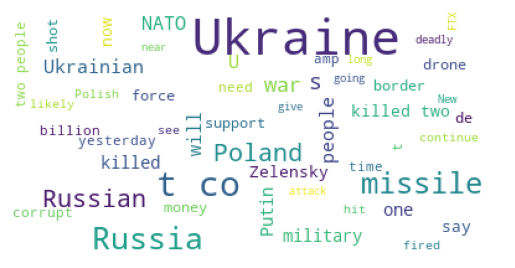

In [112]:

postivie_df = df.loc[df["Sentiment"] == "Positive"]

all_reviews = " ".join(postivie_df["Tweet"].values)

wordcloud = WordCloud().generate(all_reviews)

# take relative word frequencies into account, lower max_font_size
wordcloud = WordCloud(background_color="white",max_words=50,max_font_size=40, relative_scaling=.5).generate(all_reviews)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# Looking at the cloud of negative Tweets

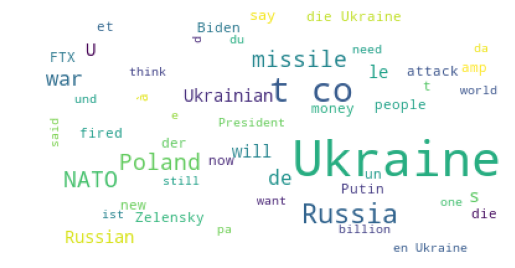

In [113]:

negative_df = df.loc[df["Sentiment"] == "Negative"]

all_reviews = " ".join(negative_df["Tweet"].values)

wordcloud = WordCloud().generate(all_reviews)

# take relative word frequencies into account, lower max_font_size
wordcloud = WordCloud(background_color="white",max_words=50,max_font_size=40, relative_scaling=.5).generate(all_reviews)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# Count vectorizer

In [114]:
class CountVect:
    def __init__(self) -> None:
        self._dictionary: List[str] = []

    def fit(self, X: List[str]) -> None:
        all_words = " ".join(X).lower().split()
        self._dictionary = sorted(list(set(all_words)))

    def transform(self, X: List[str]) -> List[List[int]]:
        results: List[List[int]] = []
        for entry in X:
            entry = entry.lower()
            unique_words = sorted(entry.split())
            words_in_dict = [word for word in unique_words if words in self._dictionary]
            words_counter = Counter(words_in_dict)
            results.append(words_counter.values())

        return results

In [115]:
cv = CountVectorizer()

cv.fit(df["Tweet"].values)
print("dictionary: ", cv.get_feature_names_out(), "size: ", len(cv.get_feature_names_out()))
result = cv.transform(["I’m calling for an audit of all US"]).toarray()
print(result)


dictionary:  ['00' '000' '02' ... '２０カ所の主にエネルギーインフラを標的にして' '８５カ所' 'ｎａｔｏ'] size:  8907
[[0 0 0 ... 0 0 0]]


# Removing stopwords

In [116]:
def remove_stop_words(text: str) -> str:
    text = text.lower()
    stop_words = set(stopwords.words("english"))
    return " ".join([word for word in text.split() if word not in stop_words])

In [117]:
df["Tweet"] = df["Tweet"].apply(remove_stop_words)

cv = CountVectorizer()

cv.fit(df["Tweet"].values)
print("dictionary size: ", len(cv.get_feature_names_out()))

dictionary size:  8883


In [118]:
lemmatizer = WordNetLemmatizer()

In [119]:
df["Tweet"] = df["Tweet"].apply(lambda x: " ".join([lemmatizer.lemmatize(i) for i in x.split()]))

cv = CountVectorizer(stop_words=["english"])

cv.fit(df["Tweet"].values)
print("dictionary size: ", len(cv.get_feature_names_out()))

dictionary size:  8670


In [120]:
stemmer = PorterStemmer()

In [121]:
df["Tweet"] = df["Tweet"].apply(lambda x: " ".join([lemmatizer.lemmatize(i) for i in x.split()]))
df["Tweet"] = df["Tweet"].apply(lambda x: " ".join([stemmer.stem(i) for i in x.split()]))

cv = CountVectorizer(stop_words=["english"])

cv.fit(df["Tweet"].values)
print("dictionary size: ", len(cv.get_feature_names_out()))

dictionary size:  8177


# Let's create Text transformer


In [7]:
class TextTransformer(BaseEstimator, TransformerMixin):
    def __init__(self) -> None:
        self._stemmer = PorterStemmer()
        self._lemmatizer = WordNetLemmatizer()
        
        
    def fit(self, X: pd.DataFrame, y: Optional[Any] = None):
        return self

    def _clean_tags(self, text: str) -> str:
        return re.sub(r"\@(.*?)\:", "", text).strip()

    def _clean_RT(self, text: str) -> str:
        return re.sub("RT", "", text).strip()

    def _clean_Link(self, text: str) -> str:
        return re.sub(r'http\S+', "", text).strip()

    def _transform_text(self, text: str) -> str:
        text1 = self._clean_tags(text)
        text2 = self._clean_RT(text1)
        text3 = self._clean_Link(text2)
        words = text3.lower().split()
        return " ".join([
            self._stemmer.stem(self._lemmatizer.lemmatize(word)) for word in words
        ])

    def transform(self, X: List[str], y=None) -> List[str]:
        return [self._transform_text(x) for x in X]

In [125]:
text_transformer = TextTransformer()

# Test text transformer

In [128]:
df = pd.read_csv("./data/Ukraine_10K_tweets_sentiment_analysis.csv")
df.dropna(inplace=True)
print(df.head(1)["Tweet"].values)
df = df.drop_duplicates()
df = text_transformer.fit_transform(df["Tweet"].values)
df


["RT @ChristopherJM: Zelensky also confirms CIA Director Bill Burns' Kyiv visit Tuesday, during Russia's missile attack. “Yesterday Burns sat…"]


["zelenski also confirm cia director bill burns' kyiv visit tuesday, dure russia' missil attack. “yesterday burn sat…",
 'russia acquir these vehicl from the secondhand car market, and did not captur them from ukraine.',
 'i’m call for an audit of everi singl penni that ha been sent to ukraine. thi must be done a soon a possibl for the am…',
 '"russian goal seem to be to entrench and defend for the next sever months, and then attempt a new offens in the…',
 "i see rishi just given anoth 4 and a half billion to the ukrain !!! you'd think it wa u at fekin war with russia…",
 '',
 "predict the trajectori and pace of thi war ha not been america' strong suit. provid secur assist to le…",
 'if putin took over ukraine, there wa no guarante that he wouldn’t immediately, or after a littl while, go into neighbo…',
 'ukraine: bewohnerin von cherson berichtet über russisch besatzung - »wir waren wie im gefä…',
 'can the risk of spillov from the ukrain war be contained?',
 'biden-ftx-ukrain is ever

# Creating pipeline

In [129]:
pipeline = Pipeline([
    ('cleaning', TextTransformer()),
    ('vectorizer', CountVectorizer()),
    ("model", LogisticRegression())
])

In [130]:
df = pd.read_csv("./data/Ukraine_10K_tweets_sentiment_analysis.csv")
df["label"] = df["Sentiment"].apply(lambda x: int(x == "Positive"))
df.groupby(by=["label"]).size()
df = df.drop_duplicates()
df.dropna(inplace=True)


In [131]:
train_df, test_df = train_test_split(df)

In [132]:
pipeline.fit(train_df["Tweet"].values, train_df["label"].values)

Pipeline(steps=[('cleaning', TextTransformer()),
                ('vectorizer', CountVectorizer()),
                ('model', LogisticRegression())])

# Test our model with logistic regression

In [133]:
y_true = test_df["label"].values

predictions = pipeline.predict(test_df["Tweet"].values)

print("Accuracy: ", accuracy_score(y_true, predictions))
print(classification_report(y_true, predictions))

Accuracy:  0.8615160349854227
              precision    recall  f1-score   support

           0       0.87      0.98      0.92       578
           1       0.70      0.21      0.33       108

    accuracy                           0.86       686
   macro avg       0.78      0.60      0.62       686
weighted avg       0.84      0.86      0.83       686



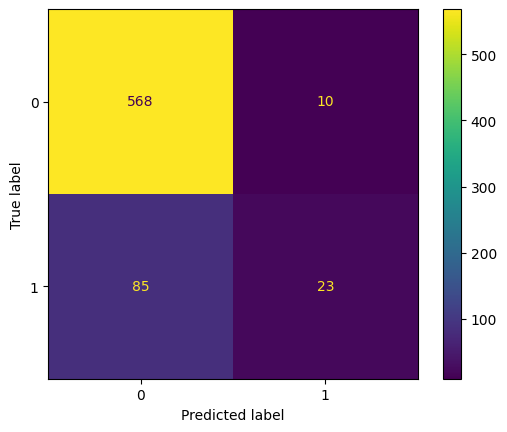

In [134]:
cm = confusion_matrix(test_df["label"], predictions, labels=test_df["label"].unique())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_df["label"].unique())
disp.plot()

# Checking feature importance

In [135]:
feature_names = pipeline.named_steps["vectorizer"].get_feature_names_out()
feature_names

array(['00', '000', '0iv3eqobpw', ..., '２０カ所の主にエネルギーインフラを標的にして', '８５カ所',
       'ｎａｔｏ'], dtype=object)

In [137]:
eli5.explain_weights(pipeline.named_steps["model"], top=50, feature_names=feature_names)

Weight?,Feature
+2.395,militari
+1.869,kill
+1.729,down
+1.670,stupid
+1.637,fals
+1.608,deadli
+1.408,destroy
+1.382,wrong
+1.347,long
+1.297,co


# Looks how decision tree can predict

In [140]:
pipeline = Pipeline([
    ('cleaning', TextTransformer()),
    ('vectorizer', CountVectorizer()),
   
    ("model", DecisionTreeClassifier())
])

In [141]:
df = pd.read_csv("./data/Ukraine_10K_tweets_sentiment_analysis.csv")
df["label"] = df["Sentiment"].apply(lambda x: int(x == "Positive"))
df.groupby(by=["label"]).size()
df = df.drop_duplicates()
df.dropna(inplace=True)

In [142]:
train_df, test_df = train_test_split(df)

In [143]:
pipeline.fit(train_df["Tweet"].values, train_df["label"].values)

Pipeline(steps=[('cleaning', TextTransformer()),
                ('vectorizer', CountVectorizer()),
                ('model', DecisionTreeClassifier())])

In [144]:
y_true = test_df["label"].values

predictions = pipeline.predict(test_df["Tweet"].values)

print("Accuracy: ", accuracy_score(y_true, predictions))
print(classification_report(y_true, predictions))

Accuracy:  0.8367346938775511
              precision    recall  f1-score   support

           0       0.89      0.92      0.90       574
           1       0.50      0.39      0.44       112

    accuracy                           0.84       686
   macro avg       0.69      0.66      0.67       686
weighted avg       0.82      0.84      0.83       686



# Try other classifier (Random Forest)

In [145]:
pipeline = Pipeline([
    ('cleaning', TextTransformer()),
    ('vectorizer', CountVectorizer()),
   
    ("model", RandomForestClassifier())
])

In [146]:
df = pd.read_csv("./data/Ukraine_10K_tweets_sentiment_analysis.csv")
df["label"] = df["Sentiment"].apply(lambda x: int(x == "Positive"))
df.groupby(by=["label"]).size()
df = df.drop_duplicates()
df.dropna(inplace=True)

In [147]:
train_df, test_df = train_test_split(df)

In [148]:
pipeline.fit(train_df["Tweet"].values, train_df["label"].values)

Pipeline(steps=[('cleaning', TextTransformer()),
                ('vectorizer', CountVectorizer()),
                ('model', RandomForestClassifier())])

In [149]:
y_true = test_df["label"].values

predictions = pipeline.predict(test_df["Tweet"].values)

print("Accuracy: ", accuracy_score(y_true, predictions))
print(classification_report(y_true, predictions))

Accuracy:  0.8425655976676385
              precision    recall  f1-score   support

           0       0.84      1.00      0.91       573
           1       0.86      0.05      0.10       113

    accuracy                           0.84       686
   macro avg       0.85      0.53      0.51       686
weighted avg       0.84      0.84      0.78       686



# Downsampling majority

In [8]:
df = pd.read_csv("./data/Ukraine_10K_tweets_sentiment_analysis.csv")
df["label"] = df["Sentiment"].apply(lambda x: int(x == "Positive"))
df.groupby(by=["label"]).size()
df = df.drop_duplicates()
df.dropna(inplace=True)


In [9]:
Negative_count = df[df['label'] == 0].shape[0]
Positive_count = df[df['label'] == 1].shape[0]

Sentiment_sample = df[df['label'] == 0].sample(frac=1 - ((Negative_count - Positive_count) / Negative_count))

balanced_df = pd.concat([Sentiment_sample, df[df['label'] == 1]])

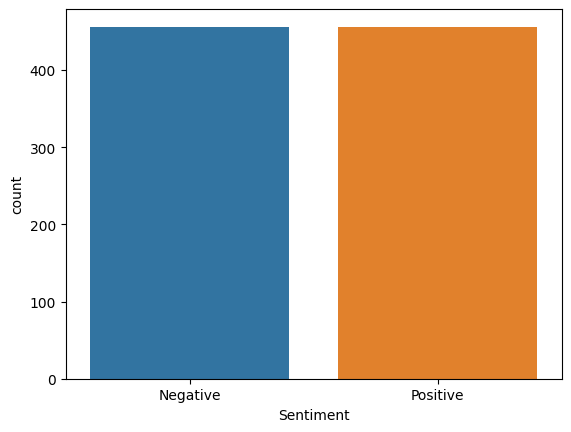

In [10]:
sns.countplot(x="Sentiment",data=balanced_df)
plt.show()

In [11]:
train_df, test_df = train_test_split(balanced_df)

In [12]:
pipeline = Pipeline([
    ('cleaning', TextTransformer()),
    ('vectorizer', CountVectorizer()),
    ("model", LogisticRegression())
])

In [13]:
pipeline.fit(train_df["Tweet"].values, train_df["label"].values)

Pipeline(steps=[('cleaning', TextTransformer()),
                ('vectorizer', CountVectorizer()),
                ('model', LogisticRegression())])

In [14]:
y_true = test_df["label"].values

predictions = pipeline.predict(test_df["Tweet"].values)

print("Accuracy: ", accuracy_score(y_true, predictions))
print(classification_report(y_true, predictions))

Accuracy:  0.6973684210526315
              precision    recall  f1-score   support

           0       0.84      0.55      0.67       125
           1       0.62      0.87      0.72       103

    accuracy                           0.70       228
   macro avg       0.73      0.71      0.69       228
weighted avg       0.74      0.70      0.69       228



In [15]:
pipeline = Pipeline([
    ('cleaning', TextTransformer()),
    ('vectorizer', CountVectorizer()),
   
    ("model", DecisionTreeClassifier())
])

In [16]:
pipeline.fit(train_df["Tweet"].values, train_df["label"].values)

Pipeline(steps=[('cleaning', TextTransformer()),
                ('vectorizer', CountVectorizer()),
                ('model', DecisionTreeClassifier())])

In [17]:
y_true = test_df["label"].values

predictions = pipeline.predict(test_df["Tweet"].values)

print("Accuracy: ", accuracy_score(y_true, predictions))
print(classification_report(y_true, predictions))

Accuracy:  0.6754385964912281
              precision    recall  f1-score   support

           0       0.76      0.60      0.67       125
           1       0.61      0.77      0.68       103

    accuracy                           0.68       228
   macro avg       0.68      0.68      0.68       228
weighted avg       0.69      0.68      0.67       228



In [18]:
pipeline = Pipeline([
    ('cleaning', TextTransformer()),
    ('vectorizer', CountVectorizer()),
   
    ("model", RandomForestClassifier())
])

In [19]:
pipeline.fit(train_df["Tweet"].values, train_df["label"].values)

Pipeline(steps=[('cleaning', TextTransformer()),
                ('vectorizer', CountVectorizer()),
                ('model', RandomForestClassifier())])

In [20]:
y_true = test_df["label"].values

predictions = pipeline.predict(test_df["Tweet"].values)

print("Accuracy: ", accuracy_score(y_true, predictions))
print(classification_report(y_true, predictions))

Accuracy:  0.6754385964912281
              precision    recall  f1-score   support

           0       0.71      0.70      0.70       125
           1       0.64      0.65      0.64       103

    accuracy                           0.68       228
   macro avg       0.67      0.67      0.67       228
weighted avg       0.68      0.68      0.68       228



# Looking at the results of the untuned models with downsample majority, we can see that the best performing model currently is Logisticregression. Now, let's try to tune the hyperparams

In [21]:
def extract_best_model_params(params: Dict[str, Any]):
    filtered_dict = {}
    for key, value in params.items():
        if "model__" in key:
            filtered_dict[key.split("model__")[-1]] = value
    return filtered_dict

In [22]:
# Logistic regression performance with hyperparam tuning

params = {
    "model__solver": ["newton-cg", "lbfgs", "liblinear"],
    "model__C": [100, 10, 1.0, 0.1, 0.01],
    "model__max_iter": randint(1000, 10000),
}

pipeline = Pipeline([
    ('cleaning', TextTransformer()),
    ('vectorizer', CountVectorizer()),
    ("model", LogisticRegression())
])

search = RandomizedSearchCV(pipeline, params, n_iter=100, cv=5, random_state=42, n_jobs=-1)
search.fit(train_df["Tweet"].values, train_df["label"])

pipeline = Pipeline([
    ('cleaning', TextTransformer()),
    ('vectorizer', CountVectorizer()),
    (
     "model",
            LogisticRegression(**extract_best_model_params(search.best_estimator_.get_params())),
    ),
    ]
)

pipeline.fit(train_df["Tweet"].values, train_df["label"])

y_true = test_df["label"].values

predictions = pipeline.predict(test_df["Tweet"].values)

print("Accuracy: ", accuracy_score(y_true, predictions))
print("f1_score: ", f1_score(y_true, predictions, average="weighted"))
print(classification_report(y_true, predictions))

Accuracy:  0.706140350877193
f1_score:  0.7040835656424095
              precision    recall  f1-score   support

           0       0.82      0.60      0.69       125
           1       0.63      0.83      0.72       103

    accuracy                           0.71       228
   macro avg       0.72      0.72      0.71       228
weighted avg       0.73      0.71      0.70       228



In [23]:
# Decision tree performance with hyperparam tuning

params = {
    "model__min_samples_leaf": randint(1, 5),
    "model__max_depth": randint(100, 200),
    # "model__min_samples_split": uniform(0.01, 0.199)
}

pipeline = Pipeline(
    [
        ("cleaning", TextTransformer()),
        ("cv", CountVectorizer()),
        ("model", DecisionTreeClassifier()),
    ]
)

search = RandomizedSearchCV(pipeline, params, n_iter=100, cv=5, random_state=42, n_jobs=-1)
search.fit(train_df["Tweet"].values, train_df["label"].values)

pipeline = Pipeline(
    [
        ("cleaningr", TextTransformer()),
        ("cv", CountVectorizer()),
        (
            "model",
            DecisionTreeClassifier(
                **extract_best_model_params(search.best_estimator_.get_params())
            ),
        ),
    ]
)

pipeline.fit(train_df["Tweet"].values, train_df["label"].values)

y_true = test_df["label"].values

predictions = pipeline.predict(test_df["Tweet"].values)

print("Accuracy: ", accuracy_score(y_true, predictions))
print("f1_score: ", f1_score(y_true, predictions, average="weighted"))
print(classification_report(y_true, predictions))

Accuracy:  0.6798245614035088
f1_score:  0.6799539053084493
              precision    recall  f1-score   support

           0       0.75      0.62      0.68       125
           1       0.62      0.75      0.68       103

    accuracy                           0.68       228
   macro avg       0.69      0.69      0.68       228
weighted avg       0.69      0.68      0.68       228



In [24]:
# Random forrest performance with hyperparam tuning

params = {
    "model__n_estimators": randint(5, 500),
    "model__min_samples_leaf": randint(1, 5),
    "model__max_depth": randint(100, 200),
    # "model__min_samples_split": uniform(0.01, 0.199)
}

pipeline = Pipeline([
    ('cleaning', TextTransformer()),
    ('vectorizer', CountVectorizer()),
   
    ("model", RandomForestClassifier())
])

search = RandomizedSearchCV(pipeline, params, n_iter=100, cv=5, random_state=42, n_jobs=-1)
search.fit(train_df["Tweet"].values, train_df["label"])

pipeline = Pipeline([
    ('cleaning', TextTransformer()),
    ('vectorizer', CountVectorizer()),
   
    (
    "model",
            RandomForestClassifier(**extract_best_model_params(search.best_estimator_.get_params())),
    ),
]
)

pipeline.fit(train_df["Tweet"].values, train_df["label"])

y_true = test_df["label"].values

predictions = pipeline.predict(test_df["Tweet"].values)

print("Accuracy: ", accuracy_score(y_true, predictions))
print("f1_score: ", f1_score(y_true, predictions, average="weighted"))
print(classification_report(y_true, predictions))

Accuracy:  0.6535087719298246
f1_score:  0.6482801593604919
              precision    recall  f1-score   support

           0       0.77      0.52      0.62       125
           1       0.58      0.82      0.68       103

    accuracy                           0.65       228
   macro avg       0.68      0.67      0.65       228
weighted avg       0.69      0.65      0.65       228



# After an extensive hyperparam tuning we can say, that Logistic regression is the best model out of all compared ones. We will use it during inference.

# Now we make columntransformer which add polarity column to improve accuracy, for that we need upgrade Texttransformer

In [25]:
class TextTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, _column_name) -> None:
        self._stemmer = PorterStemmer()
        self._lemmatizer = WordNetLemmatizer()
        self._column_name = _column_name
        
    def fit(self, X: pd.DataFrame, y: Optional[Any] = None):
        return self

    def _clean_tags(self, text: str) -> str:
        return re.sub(r"\@(.*?)\:", "", text).strip()

    def _clean_RT(self, text: str) -> str:
        return re.sub("RT", "", text).strip()

    def _clean_Link(self, text: str) -> str:
        return re.sub(r'http\S+', "", text).strip()

    def _transform_text(self, text: str) -> str:
        text1 = self._clean_tags(text)
        text2 = self._clean_RT(text1)
        text3 = self._clean_Link(text2)
        words = text3.lower().split()
        return " ".join([
            self._stemmer.stem(self._lemmatizer.lemmatize(word)) for word in words
        ])

    def transform(self, X: pd.DataFrame, y: Optional[Any] = None) -> pd.DataFrame:
        data = X.copy()
        data[self._column_name] = data[self._column_name].apply(self._transform_text)
        return data

In [26]:
cont_features = ["polarity"]
cat_features = "Tweet"
label = "Sentiment"

In [27]:
cont_pipeline = Pipeline([
    
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    
    ('vectorizer', CountVectorizer())
    ])

In [28]:
pipeline = Pipeline([
    ('cleaning', TextTransformer("Tweet")),
    ("ColumnTransformer", ColumnTransformer([
        ("cont_transformer", cont_pipeline, cont_features),
        ("cat_transformer", cat_pipeline, cat_features)
    ])),
    ("model", LogisticRegression())
])

In [30]:
df = pd.read_csv("./data/Ukraine_10K_tweets_sentiment_analysis.csv")
df["label"] = df["Sentiment"].apply(lambda x: int(x == "Positive"))
df.groupby(by=["label"]).size()
df = df.drop_duplicates()
df.dropna(inplace=True)

Negative_count = df[df['label'] == 0].shape[0]
Positive_count = df[df['label'] == 1].shape[0]

Sentiment_sample = df[df['label'] == 0].sample(frac=1 - ((Negative_count - Positive_count) / Negative_count))

balanced_df = pd.concat([Sentiment_sample, df[df['label'] == 1]])

In [31]:
train_df, test_df = train_test_split(balanced_df)

In [32]:
pipeline.fit(train_df, train_df["label"].values)

Pipeline(steps=[('cleaning', TextTransformer(_column_name='Tweet')),
                ('ColumnTransformer',
                 ColumnTransformer(transformers=[('cont_transformer',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['polarity']),
                                                 ('cat_transformer',
                                                  Pipeline(steps=[('vectorizer',
                                                                   CountVectorizer())]),
                                                  'Tweet')])),
                ('model', LogisticRegression())])

In [33]:
y_true = test_df["label"].values

predictions = pipeline.predict(test_df)

print("Accuracy: ", accuracy_score(y_true, predictions))
print(classification_report(y_true, predictions))

Accuracy:  0.9736842105263158
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       111
           1       0.99      0.96      0.97       117

    accuracy                           0.97       228
   macro avg       0.97      0.97      0.97       228
weighted avg       0.97      0.97      0.97       228



In [168]:
print("Baseline")

predictions = baseline.predict(test_df["polarity"].values)

print("MAE: ", mean_absolute_error(test_df['label'].values, predictions))
print("MSE: ", mean_squared_error(test_df['label'].values, predictions))

Baseline


ValueError: Found input variables with inconsistent numbers of samples: [228, 684]

In [17]:
# Exporting model
cloudpickle.dump(pipeline, open("./outputs/tweet_model.pkl", "wb"))

In [24]:
clmodel = cloudpickle.load(open("./outputs/tweet_model.pkl", "rb"))

In [25]:
clmodel

Pipeline(steps=[('cleaning', TextTransformer(_column_name='Tweet')),
                ('ColumnTransformer',
                 ColumnTransformer(transformers=[('cont_transformer',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['polarity']),
                                                 ('cat_transformer',
                                                  Pipeline(steps=[('vectorizer',
                                                                   CountVectorizer())]),
                                                  'Tweet')])),
                ('model', RandomForestClassifier())])